### Variational Autoencoder.
Implementation on MNIST, Fashion MNIST and CIFR10.

# MNIST handwritten Digit Dataset

In [1]:
# Import all the required libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import InputLayer, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
import matplotlib.pyplot as plt

Epoch 1/50
547/547 [==============================] - 27s 20ms/step - loss: 252.1270 - reconstruction_loss: 205.5363 - kl_loss: 3.3799
Epoch 2/50
547/547 [==============================] - 9s 17ms/step - loss: 184.8190 - reconstruction_loss: 180.1485 - kl_loss: 2.8205
Epoch 3/50
547/547 [==============================] - 9s 17ms/step - loss: 179.0173 - reconstruction_loss: 174.7928 - kl_loss: 3.0849
Epoch 4/50
547/547 [==============================] - 5s 10ms/step - loss: 175.4614 - reconstruction_loss: 171.6625 - kl_loss: 3.3265
Epoch 5/50
547/547 [==============================] - 5s 8ms/step - loss: 173.5191 - reconstruction_loss: 169.5892 - kl_loss: 3.4834
Epoch 6/50
547/547 [==============================] - 4s 8ms/step - loss: 171.8498 - reconstruction_loss: 168.1541 - kl_loss: 3.6102
Epoch 7/50
547/547 [==============================] - 5s 9ms/step - loss: 168.1551 - reconstruction_loss: 160.2773 - kl_loss: 5.1726
Epoch 8/50
547/547 [==============================] - 4s 8ms/ste

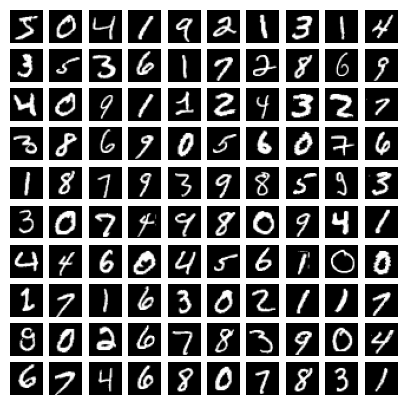

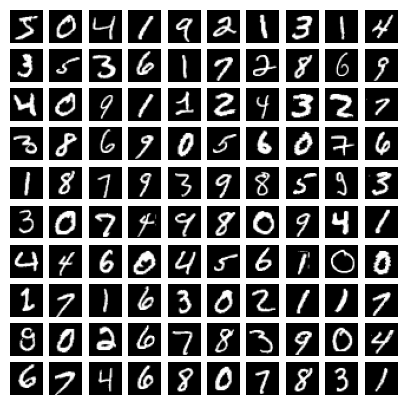

In [2]:
# Parameters
img_height, img_width, img_channel = 28, 28, 1
n_batch = 128
n_epoch = 50
latent_dim = 2

# Load the MNIST dataset
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist = np.concatenate([x_train, x_test], axis=0)
mnist = np.expand_dims(mnist, -1).astype("float32") / 255

# Visualize our data
plt.figure(figsize=(5, 5))
for i in range(100):
    ax = plt.subplot(10, 10, i + 1)
    plt.imshow(mnist[i], cmap ='gray')
    plt.axis("off")


    # Visualize our data
plt.figure(figsize=(5, 5))
for i in range(100):
    ax = plt.subplot(10, 10, i + 1)
    plt.imshow(mnist[i], cmap ='gray')
    plt.axis("off")

    # Define the VAE as a Model with a custom train_step
class VAE(keras.Model):
    def __init__(self, **kwargs):
        super(VAE, self).__init__(**kwargs)

        # encoder
        self.encoder = tf.keras.Sequential([
            InputLayer(input_shape=(img_height, img_width, img_channel)),
            Conv2D(32, 3, activation="relu", strides=2, padding="same"),
            Conv2D(64, 3, activation="relu", strides=2, padding="same"),
            Flatten(),
            Dense(16, activation="relu"),
            Dense(latent_dim),
        ])

        # reparameterization/sampling layer
        self.z_mean = Dense(latent_dim, name="z_mean")
        self.z_log_var = Dense(latent_dim, name="z_log_var")

        # decoder
        self.decoder = tf.keras.Sequential([
            InputLayer(input_shape=(latent_dim,)),
            Dense(7 * 7 * 64, activation="relu"),
            Reshape((7, 7, 64)),
            Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same"),
            Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same"),
            Conv2DTranspose(1, 3, activation="sigmoid", padding="same"),
        ])

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")


    # Build the encoder
    def encode(self, data):
        x = self.encoder(data)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        return z_mean, z_log_var

    # Build the reparameterization/sampling layer
    def reparameterization(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        z =  z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return z

    # Build the decoder
    def decode(self, data):
        return self.decoder(data)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encode(data)
            z = self.reparameterization(z_mean, z_log_var)
            reconstruction = self.decode(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Train the VAE
vae = VAE()
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist, epochs= n_epoch, batch_size= n_batch)

1/1 [==============================] - 0s 17ms/step


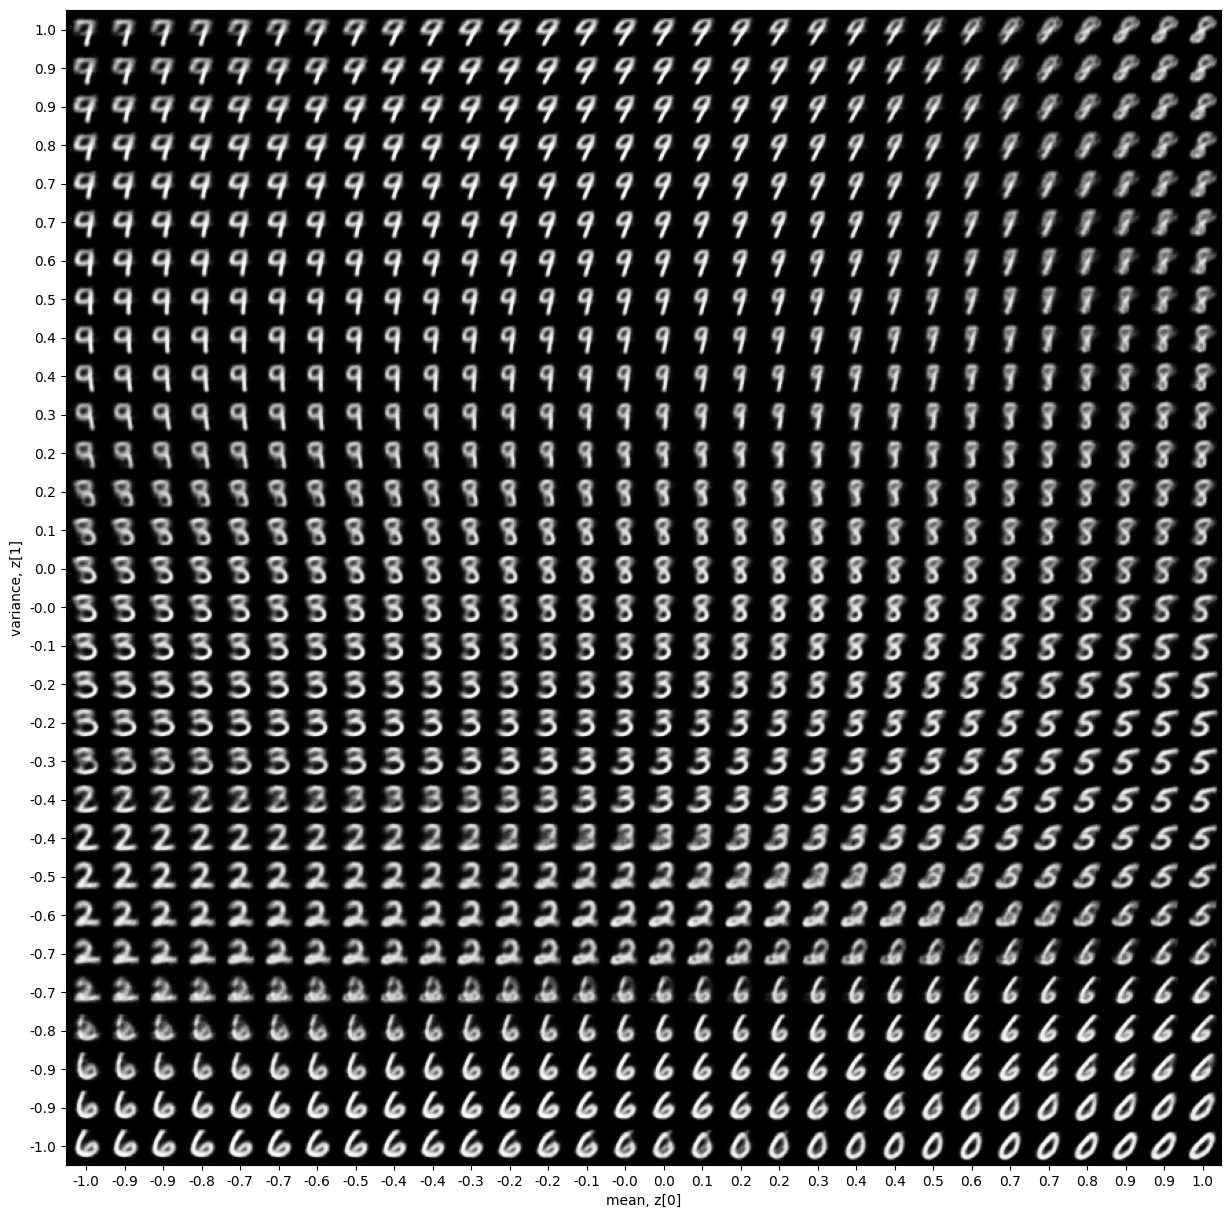

In [3]:
# Display a grid of sampled classes
def plot_latent_space(vae, n=30, figsize=15):
    img_height = 28
    scale = 1.0
    figure = np.zeros((img_height * n, img_height * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            classes = x_decoded[0].reshape(img_height, img_height)
            figure[
                i * img_height : (i + 1) * img_height,
                j * img_height : (j + 1) * img_height,
            ] = classes

    plt.figure(figsize=(figsize, figsize))
    start_range = img_height // 2
    end_range = n * img_height + start_range
    pixel_range = np.arange(start_range, end_range, img_height)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z[0]")
    plt.ylabel("variance, z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(vae)

### MNIST Fashion dataset

Epoch 1/10
547/547 [==============================] - 8s 8ms/step - loss: 373.9177 - reconstruction_loss: 319.5382 - kl_loss: 8.2460
Epoch 2/10
547/547 [==============================] - 5s 9ms/step - loss: 292.1101 - reconstruction_loss: 279.5253 - kl_loss: 9.2557
Epoch 3/10
547/547 [==============================] - 5s 8ms/step - loss: 280.4836 - reconstruction_loss: 270.5717 - kl_loss: 8.0078
Epoch 4/10
547/547 [==============================] - 4s 8ms/step - loss: 273.8359 - reconstruction_loss: 266.0805 - kl_loss: 7.2794
Epoch 5/10
547/547 [==============================] - 5s 9ms/step - loss: 271.6294 - reconstruction_loss: 263.5815 - kl_loss: 7.0746
Epoch 6/10
547/547 [==============================] - 4s 8ms/step - loss: 269.4372 - reconstruction_loss: 262.1505 - kl_loss: 6.9600
Epoch 7/10
547/547 [==============================] - 4s 8ms/step - loss: 268.3502 - reconstruction_loss: 260.9311 - kl_loss: 6.9484
Epoch 8/10
547/547 [==============================] - 5s 9ms/step - l

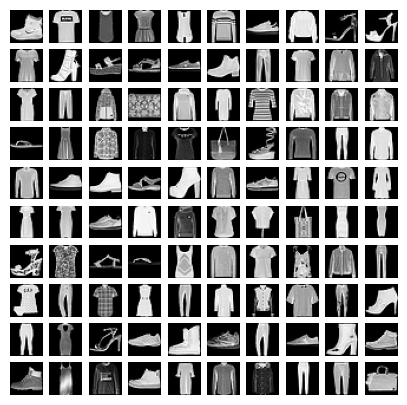

In [5]:
# Parameters
img_height, img_width, img_channel = 28, 28, 1
n_batch = 128
n_epoch = 10
latent_dim = 2

# Load the MNIST dataset
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
mnist = np.concatenate([x_train, x_test], axis=0)
mnist = np.expand_dims(mnist, -1).astype("float32") / 255

# Visualize our data
plt.figure(figsize=(5, 5))
for i in range(100):
    ax = plt.subplot(10, 10, i + 1)
    plt.imshow(mnist[i], cmap ='gray')
    plt.axis("off")
    # Define the VAE as a Model with a custom train_step
class VAE(keras.Model):
    def __init__(self, **kwargs):
        super(VAE, self).__init__(**kwargs)

        # encoder
        self.encoder = tf.keras.Sequential([
            InputLayer(input_shape=(img_height, img_width, img_channel)),
            Conv2D(32, 3, activation="relu", strides=2, padding="same"),
            Conv2D(64, 3, activation="relu", strides=2, padding="same"),
            Flatten(),
            Dense(16, activation="relu"),
            Dense(latent_dim),
        ])

        # reparameterization/sampling layer
        self.z_mean = Dense(latent_dim, name="z_mean")
        self.z_log_var = Dense(latent_dim, name="z_log_var")

        # decoder
        self.decoder = tf.keras.Sequential([
            InputLayer(input_shape=(latent_dim,)),
            Dense(7 * 7 * 64, activation="relu"),
            Reshape((7, 7, 64)),
            Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same"),
            Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same"),
            Conv2DTranspose(1, 3, activation="sigmoid", padding="same"),
        ])

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")


    # Build the encoder
    def encode(self, data):
        x = self.encoder(data)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        return z_mean, z_log_var

    # Build the reparameterization/sampling layer
    def reparameterization(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        z =  z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return z

    # Build the decoder
    def decode(self, data):
        return self.decoder(data)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encode(data)
            z = self.reparameterization(z_mean, z_log_var)
            reconstruction = self.decode(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Train the VAE
vae = VAE()
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist, epochs= n_epoch, batch_size= n_batch)

1/1 [==============================] - 0s 19ms/step


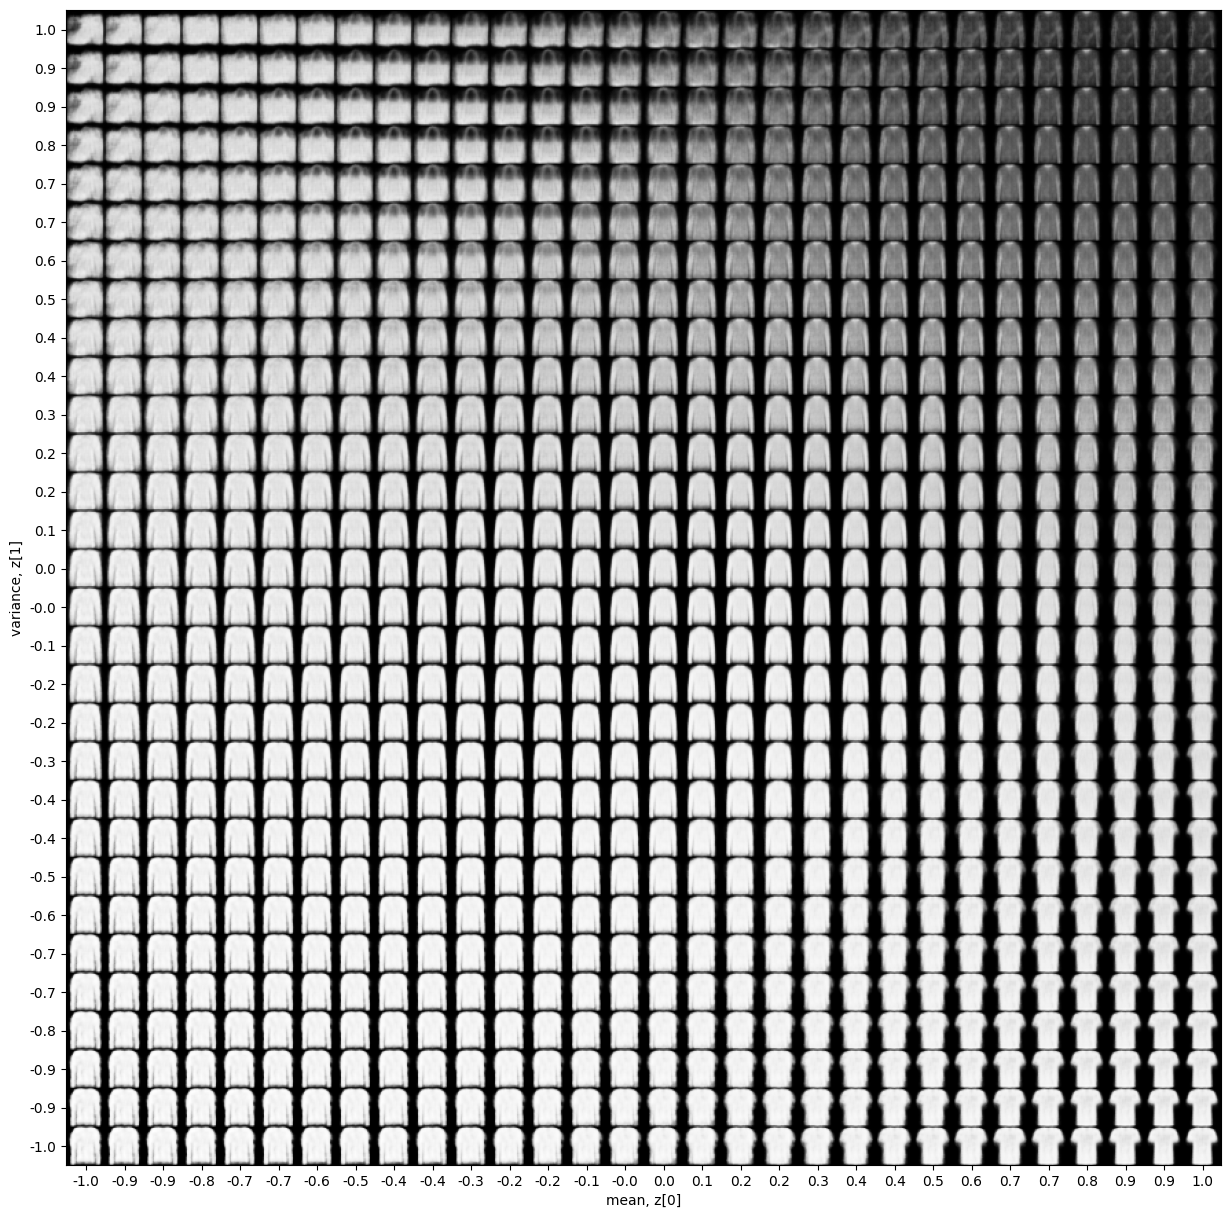

In [6]:
# Display a grid of sampled classes
def plot_latent_space(vae, n=30, figsize=15):
    img_height = 28
    scale = 1.0
    figure = np.zeros((img_height * n, img_height * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            classes = x_decoded[0].reshape(img_height, img_height)
            figure[
                i * img_height : (i + 1) * img_height,
                j * img_height : (j + 1) * img_height,
            ] = classes

    plt.figure(figsize=(figsize, figsize))
    start_range = img_height // 2
    end_range = n * img_height + start_range
    pixel_range = np.arange(start_range, end_range, img_height)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z[0]")
    plt.ylabel("variance, z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(vae)

### CIFAR 10 dataset

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import InputLayer, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose

# Parameters
img_height, img_width, img_channel = 32, 32, 3  # CIFAR-10 images have dimensions 32x32x3
n_batch = 128
n_epoch = 10
latent_dim = 2

# Load CIFAR-10 dataset
(x_train, _), (x_test, _) = keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Define the VAE as a Model with a custom train_step
class VAE(keras.Model):
    def __init__(self, **kwargs):
        super(VAE, self).__init__(**kwargs)

        # encoder
        self.encoder = tf.keras.Sequential([
            InputLayer(input_shape=(img_height, img_width, img_channel)),
            Conv2D(32, 3, activation="relu", strides=2, padding="same"),
            Conv2D(64, 3, activation="relu", strides=2, padding="same"),
            Flatten(),
            Dense(16, activation="relu"),
            Dense(latent_dim),
        ])

        # reparameterization/sampling layer
        self.z_mean = Dense(latent_dim, name="z_mean")
        self.z_log_var = Dense(latent_dim, name="z_log_var")

        # decoder
        self.decoder = tf.keras.Sequential([
            InputLayer(input_shape=(latent_dim,)),
            Dense(8 * 8 * 64, activation="relu"),
            Reshape((8, 8, 64)),
            Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same"),
            Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same"),
            Conv2DTranspose(3, 3, activation="sigmoid", padding="same"),
        ])

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    # Build the encoder
    def encode(self, data):
        x = self.encoder(data)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        return z_mean, z_log_var

    # Build the reparameterization/sampling layer
    def reparameterization(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        z =  z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return z

    # Build the decoder
    def decode(self, data):
        return self.decoder(data)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
      with tf.GradientTape() as tape:
        z_mean, z_log_var = self.encode(data)
        z = self.reparameterization(z_mean, z_log_var)
        reconstruction = self.decode(z)
        # Compute binary cross-entropy loss per channel
        reconstruction_loss = tf.reduce_sum(
            keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
        )
        reconstruction_loss = tf.reduce_mean(reconstruction_loss)
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss
      grads = tape.gradient(total_loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
      self.total_loss_tracker.update_state(total_loss)
      self.reconstruction_loss_tracker.update_state(reconstruction_loss)
      self.kl_loss_tracker.update_state(kl_loss)
      return {
        "loss": self.total_loss_tracker.result(),
        "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        "kl_loss": self.kl_loss_tracker.result(),
    }


# Train the VAE
vae = VAE()
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=n_epoch, batch_size=n_batch)


Epoch 1/10
391/391 [==============================] - 7s 10ms/step - loss: 706.6313 - reconstruction_loss: 706.1131 - kl_loss: 4.5174e-04
Epoch 2/10
391/391 [==============================] - 4s 11ms/step - loss: 705.9004 - reconstruction_loss: 705.8128 - kl_loss: 5.3975e-04
Epoch 3/10
391/391 [==============================] - 4s 10ms/step - loss: 705.8580 - reconstruction_loss: 705.7734 - kl_loss: 3.9987e-04
Epoch 4/10
391/391 [==============================] - 4s 9ms/step - loss: 705.7062 - reconstruction_loss: 705.7280 - kl_loss: 2.0236e-04
Epoch 5/10
391/391 [==============================] - 4s 11ms/step - loss: 705.8227 - reconstruction_loss: 705.7262 - kl_loss: 1.2391e-04
Epoch 6/10
391/391 [==============================] - 4s 10ms/step - loss: 705.7160 - reconstruction_loss: 705.7242 - kl_loss: 9.2745e-05
Epoch 7/10
391/391 [==============================] - 4s 10ms/step - loss: 705.6386 - reconstruction_loss: 705.6992 - kl_loss: 1.1834e-04
Epoch 8/10
391/391 [===============

4/4 [==============================] - 0s 19ms/step


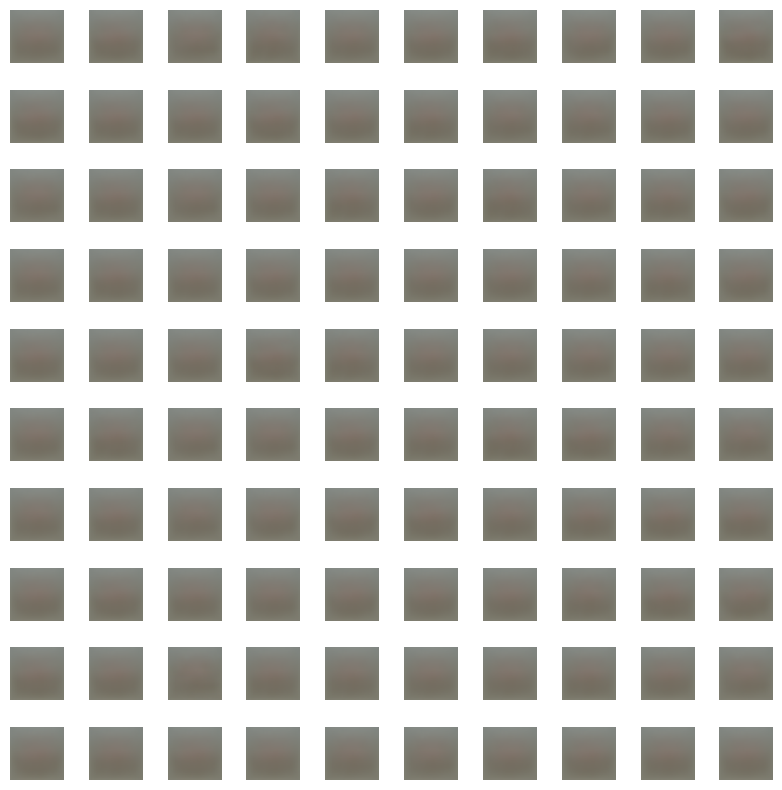

In [10]:
# Display a grid of sampled images from the latent space
def plot_generated_images(vae, n=10, figsize=10):
    # Generate random samples from the latent space
    random_samples = np.random.normal(0, 1, (n * n, latent_dim))
    generated_images = vae.decoder.predict(random_samples)

    # Rescale images to [0, 1] range
    generated_images = np.clip(generated_images, 0, 1)

    # Create a grid of images
    fig, axes = plt.subplots(n, n, figsize=(figsize, figsize))
    fig.subplots_adjust(hspace=0.5)
    for i in range(n):
        for j in range(n):
            ax = axes[i, j]
            ax.imshow(generated_images[i * n + j])
            ax.axis('off')

    plt.show()

# Generate and display a grid of sampled images from the latent space
plot_generated_images(vae)